In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [3]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [4]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())

0 / 200000, loss: 26.08124351501465
10000 / 200000, loss: 2.725921154022217
20000 / 200000, loss: 2.570828676223755
30000 / 200000, loss: 2.017261505126953
40000 / 200000, loss: 1.702070951461792
50000 / 200000, loss: 2.7097530364990234
60000 / 200000, loss: 2.183368682861328
70000 / 200000, loss: 2.666766405105591
80000 / 200000, loss: 2.1898810863494873
90000 / 200000, loss: 1.8629530668258667
100000 / 200000, loss: 1.9521985054016113
110000 / 200000, loss: 2.348328113555908
120000 / 200000, loss: 2.0691957473754883
130000 / 200000, loss: 2.158890962600708
140000 / 200000, loss: 2.1405539512634277
150000 / 200000, loss: 2.2354896068573
160000 / 200000, loss: 2.292982339859009
170000 / 200000, loss: 2.170783519744873
180000 / 200000, loss: 1.94773530960083
190000 / 200000, loss: 2.181471824645996


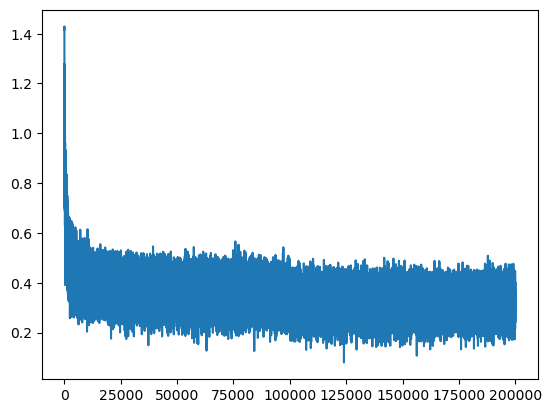

In [6]:
plt.plot(lossi)

In [7]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.1173901557922363
val 2.1572394371032715


In [14]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        out.append(ix)
        if ix==0:
            break
    print("".join(itos[i] for i in out))

pro.
evy.
leeyukien.
noto.
raya.
copton.
kaylin.
dadajuel.
cimbacai.
emais.
rayton.
jaya.
areotymira.
kyham.
arius.
thik.
anto.
marshan.
aubrensie.
sadhan.
